<a href="https://colab.research.google.com/github/tori3112/facial-bias-ml/blob/main/Copy_of_MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating a Pipeline**

# Stage 0 : importing

In [ ]:
"""Import all required libraries for the pipeline"""
global os, drive, np, Image, ET, train_test_split
global VGG16, Model, Dense, GlobalAveragePooling2D, Dropout
global Adam, EarlyStopping, ReduceLROnPlateau
global plt, classification_report, accuracy_score

import os
import json
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import gc
import seaborn as sns

print("All libraries imported successfully")

All libraries imported successfully


# Stage 1 : Creating Suitable Training Data from dataset in filepath

In [ ]:
training_filepath = "/content/drive/MyDrive/46w04a06b04i_50images_each.zip"
"""
First function in the pipeline that processes the training data
Input: training_filepath - path to zip file in Google Drive
Output: X (images), y (labels), id_to_label mapping
"""
# Mount drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Get the base name of the zip file (without .zip extension)
base_name = os.path.splitext(os.path.basename(training_filepath))[0]

# Create the dataset path based on the zip file name
dataset_path = f'/content/dataset/{base_name}'

# Ensure dataset directory exists and unzip
if not os.path.exists('/content/dataset'):
    os.makedirs('/content/dataset')

# Only unzip if the dataset directory is empty
if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    from zipfile import ZipFile
    print(f"Unzipping {training_filepath} to {dataset_path}")
    try:
        with ZipFile(training_filepath, 'r') as zip_ref:
            zip_ref.extractall('/content/dataset')
        print("Unzipping completed successfully")
    except Exception as e:
        print(f"Error during unzipping: {str(e)}")
        raise
print("Dataset contents:", os.listdir(dataset_path))

def parse_xml_labels(xml_path, dataset_path):
  tree = ET.parse(xml_path)
  root = tree.getroot()

  # Get all person IDs from all ethnicity folders
  all_person_folders = set()
  for ethnicity_folder in os.listdir(dataset_path):
      ethnicity_path = os.path.join(dataset_path, ethnicity_folder)
      all_person_folders.update(os.listdir(ethnicity_path))

  # Create the label mapping
  id_to_label = {}
  for subject in root.findall('subject'):
      person_id = subject.find('id').text
      if person_id in all_person_folders:
          id_to_label[person_id] = len(id_to_label)

  return id_to_label

def load_dataset(dataset_path, id_to_label):
    images = []
    labels = []

    # First level: ethnicity folders
    for ethnicity_folder in os.listdir(dataset_path):
        ethnicity_path = os.path.join(dataset_path, ethnicity_folder)
        if not os.path.isdir(ethnicity_path):
            continue

        print(f"Processing ethnicity folder: {ethnicity_folder}")

        # Second level: person folders within each ethnicity folder
        for person_folder in os.listdir(ethnicity_path):
            person_path = os.path.join(ethnicity_path, person_folder)
            if not os.path.isdir(person_path):
                continue

            if person_folder in id_to_label:
                label = id_to_label[person_folder]

                # Third level: image files within person folders
                for img_name in os.listdir(person_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(person_path, img_name)
                        try:
                            img = Image.open(img_path)
                            img = img.resize((224, 224))  # Resize for VGG16
                            img_array = np.array(img, dtype=np.float32)

                            # Handle grayscale images
                            if len(img_array.shape) == 2:
                                img_array = np.stack((img_array,)*3, axis=-1)

                            # Normalize pixel values
                            img_array /= 255.0

                            images.append(img_array)
                            labels.append(label)
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

# Note: XML file stays in Google Drive but dataset is in local Colab storage
xml_path = '/content/drive/MyDrive/finalTrain.xml'

# Create label mapping
id_to_label = parse_xml_labels(xml_path, dataset_path)
print(f"Found {len(id_to_label)} unique individuals")

# Load the dataset
X, y = load_dataset(dataset_path, id_to_label)

print(f"Processing dataset from: {base_name}")
print(f"Final dataset shapes - X: {X.shape}, y: {y.shape}")

Unzipping /content/drive/MyDrive/46w04a06b04i_50images_each.zip to /content/dataset/46w04a06b04i_50images_each
Unzipping completed successfully
Dataset contents: ['Asian Indian', 'East Asian', 'Caucasian Latin', 'African American']
Found 60 unique individuals
Processing ethnicity folder: Asian Indian
Processing ethnicity folder: East Asian
Processing ethnicity folder: Caucasian Latin
Processing ethnicity folder: African American
Processing dataset from: 46w04a06b04i_50images_each
Final dataset shapes - X: (3000, 224, 224, 3), y: (3000,)


# Stage 2 : Defining Testing Data

In [ ]:
"""
Second function in the pipeline that splits the data
"""
# First split off test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Split remaining data into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

print("\nSplit sizes:")
print(f"Training: {X_train.shape[0]} images")
print(f"Validation: {X_val.shape[0]} images")
print(f"Test: {X_test.shape[0]} images")


Split sizes:
Training: 1800 images
Validation: 600 images
Test: 600 images


# Stage 3 : Creating the Model

In [ ]:
"""
Third function in the pipeline that creates the model architecture
Input: number of classes (from len(id_to_label))
Output: compiled model
"""
num_classes = 60
# 2. Load the base VGG16 model
base_model = VGG16(
    weights='imagenet',      # Use pre-trained weights from ImageNet
    include_top=False,       # Don't include the original classification layers
    input_shape=(224, 224, 3), # Our image dimensions
)

# 3. Freeze the VGG16 layers (we don't want to train them initially)
for layer in base_model.layers:
    layer.trainable = False

# 4. Add our own custom classification layers on top of VGG16
x = base_model.output
# Add Global Average Pooling to reduce dimensions
x = GlobalAveragePooling2D()(x)
# Add first Dense layer with dropout
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevent overfitting
# Add second Dense layer with dropout
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# Final classification layer
predictions = Dense(num_classes, activation='softmax')(x)

# 5. Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# 6. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Conservative learning rate
    loss='sparse_categorical_crossentropy', # Because our labels are integers
    metrics=['accuracy']
)

print("Model compiled")

Model compiled


# Stage 4 : Train the model

In [ ]:
"""
Fourth function in the pipeline that trains the model
Input: model and training/validation data
Output: trained model and training history
"""
# 7. Set up callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,         # Wait 5 epochs before stopping
        restore_best_weights=True  # Keep the best weights
    ),

    # Reduce learning rate when improvement slows
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,         # Reduce LR by 80% when plateau occurs
            patience=5,         # Wait 5 epochs before reducing
            min_lr=1e-6        # Don't go below this LR
        )
]
print("defined callback")

# 8. Train the model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,             # Maximum number of epochs
    batch_size=16,         # Batch size - adjust based on your GPU memory
    callbacks=callbacks
)

print(f"Training with {X_train.shape[0]} images across {len(np.unique(y_train))} classes")

defined callback
Starting training...
Epoch 1/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.1004 - loss: 4.5944 - val_accuracy: 0.1317 - val_loss: 3.9368 - learning_rate: 1.0000e-04
Epoch 2/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.0869 - loss: 3.9828 - val_accuracy: 0.1500 - val_loss: 3.8866 - learning_rate: 1.0000e-04
Epoch 3/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.0983 - loss: 3.9253 - val_accuracy: 0.1483 - val_loss: 3.8449 - learning_rate: 1.0000e-04
Epoch 4/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.1016 - loss: 3.8649 - val_accuracy: 0.1467 - val_loss: 3.8077 - learning_rate: 1.0000e-04
Epoch 5/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.1188 - loss: 3.8269 - val_accuracy: 0.1517 - val_loss: 3.7630 - learning_rate: 1.0000e-04
Epoch 6/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.1041 - loss: 3.8148 - val_accuracy: 0.1617 - val_loss: 3.7246 - learning_rate: 1.0000e-04
Epoch 7/60
113/

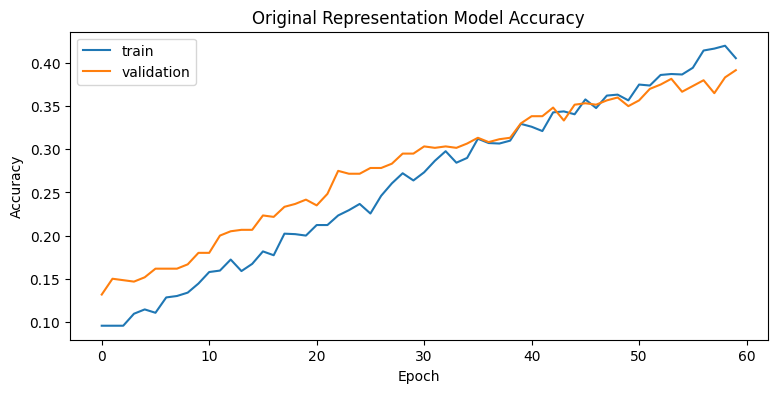

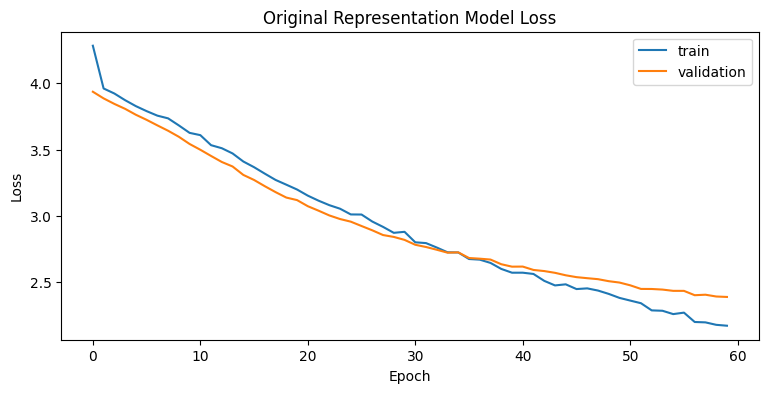

In [ ]:
history.history.keys()
# summarize history for accuracy
plt.figure(figsize=(9,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Original Representation Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.figure(figsize=(9,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Original Representation Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Evaluate Model Accuracy per Ethnicity

In [ ]:
"""
Fifth function in the pipeline that evaluates model accuracy per ethnicity
Input: model, test data, label mapping
Output: accuracies per ethnicity group
"""
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Load XML file to get ethnicity information
tree = ET.parse('/content/drive/MyDrive/finalTrain.xml')
root = tree.getroot()

# Create mapping of person ID to ethnicity
id_to_ethnicity = {}
for subject in root.findall('subject'):
    person_id = subject.find('id').text
    ethnicity = int(subject.find('ethnicity').text)
    id_to_ethnicity[person_id] = ethnicity

# Create reverse mapping for label to ID
label_to_id = {v: k for k, v in id_to_label.items()}

# Calculate accuracy per ethnicity
ethnicity_mapping = {
    1: 'African American',
    2: 'Asian Indian',
    3: 'Caucasian Latin',
    4: 'East Asian'
}

# Store accuracies
ethnicity_accuracies = {}

# for eth_num, eth_name in ethnicity_mapping.items():
#     # Get indices of test samples for this ethnicity
#     eth_indices = []
#     for i, label in enumerate(y_test):
#         person_id = label_to_id[label]
#         if id_to_ethnicity[person_id] == eth_num:
#             eth_indices.append(i)

#     # Calculate accuracy for this ethnicity
#     eth_correct = sum(1 for i in eth_indices if y_pred_classes[i] == y_test[i])
#     eth_accuracy = eth_correct / len(eth_indices) if eth_indices else 0
#     ethnicity_accuracies[eth_name] = eth_accuracy

# Plot accuracies
# plt.figure(figsize=(10, 6))
# ethnicities = list(ethnicity_accuracies.keys())
# accuracies = list(ethnicity_accuracies.values())

# plt.bar(ethnicities, accuracies)
# plt.title(f'Model Accuracy by Ethnicity - {base_name}\nTrained on VGG16')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Print accuracies
print("\nAccuracies by Ethnicity:")
for eth, acc in ethnicity_accuracies.items():
    print(f"{eth}: {acc:.4f}")

# Add confusion matrix

# Convert y_test and y_pred_classes from person IDs to ethnicity labels
# eth_y_test = [id_to_ethnicity[label_to_id[label]] for label in y_test]
# eth_y_pred = [id_to_ethnicity[label_to_id[label]] for label in y_pred_classes]

# cm = confusion_matrix(y_test, y_pred_classes)
# plt.figure(figsize=(10,8))
# sns.heatmap(cm,
#             xticklabels=['African American', 'Asian Indian', 'Caucasian Latin', 'East Asian'],
#             yticklabels=['African American', 'Asian Indian', 'Caucasian Latin', 'East Asian'],
#             annot=True, fmt='d')
# plt.title(f'Confusion Matrix - {base_name}')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step

Accuracies by Ethnicity:


In [ ]:
# Create reverse mapping from label values to ethnicity values
reverse_mapping = {}
for key in id_to_label:
    if key in id_to_ethnicity:
        reverse_mapping[id_to_label[key]] = id_to_ethnicity[key]

# Map predictions
mapped_predictions = [reverse_mapping.get(int(pred), 'Unknown') for pred in y_pred_classes]
mapped_true =        [reverse_mapping.get(int(it), 'Unknown') for it in y_test]

#print(f'PREDICTIONS: {mapped_predictions}')
#print(f'TRUE: {mapped_true}')

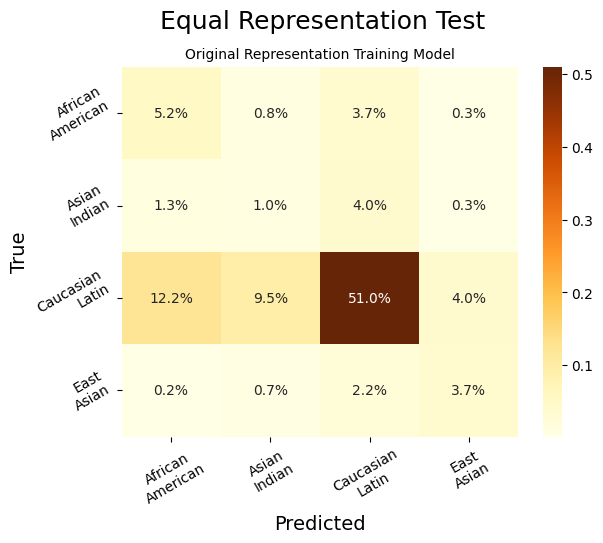

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(mapped_true, mapped_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap=sns.color_palette("YlOrBr", as_cmap=True),
            xticklabels=['African\nAmerican', 'Asian\nIndian', 'Caucasian\nLatin', 'East\nAsian'],
            yticklabels=['African\nAmerican', 'Asian\nIndian', 'Caucasian\nLatin', 'East\nAsian'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.suptitle('Equal Representation Test', fontsize=18, x=0.44, y=1.0001)
plt.title('Original Representation Training Model', fontsize=10)
plt.show()

In [ ]:
print(f'TRUE: {np.array(mapped_true)}')
print(f'PREDICTED: {np.array(mapped_predictions)}')


TRUE: ['4' '4' '4' '1' '3' '1' '1' '2' '1' '3' '2' '1' 'Unknown' '2' '1' '3' '1'
 '4' '2' '2' '4' '2' '1' '1' '1' '4' '1' '2' '1' '3' '1' '3' '1' '4' '4'
 '1' '3' '3' '1' 'Unknown' '3' '4' '1' '2' '2' '2' '2' '2' '4' '3' '4' '2'
 '1' '3' '1' '1' '4' '1' '4' '3' '1' '1' '1' '2' '3' '4' '1' '2' '1' '2'
 '2' '1' '4' '2' '4' '1' '4' '4' '1' '3' '2' '4' '3' 'Unknown' '4' '1' '4'
 '3' '3' '2' '1' '4' '3' '4' '2' '2' '3' 'Unknown' '3' '1' '2' '1' '1' '1'
 '1' '3' '2' '2' '1' '3' '3' '4' '2' '1' '3' '4' '1' '1' '2' '1' '1' '4'
 '4' '2' '3' '1' '4' '4' '2' '2' '2' 'Unknown' '4' '1' '2' '3' '4' '2' '4'
 '1' '1' '2' '2' '4' '4' '1' '4' '3' '3' '1' '4' '2' '2' '2' '2' '3' '3'
 '2' '2' '2' '1' '4' '4' '2' '4' '4' '3' '4' '1' '3' '1' '1' '1' '3' '4'
 '3' '4' '2' '4' '1' '3' '3' '1' '1' '1' '3' 'Unknown' '4' '2' '1' '4' '2'
 '3' '2' '4' '3' '4' '1' '2' '1' '1' '2' '3' '4' '1' '1' '4' '1' '2' '3'
 '1' '2' '2' '3' '1' '3' '3' '1' '1' 'Unknown' '3' '1' '4' '3' '3' '2' '4'
 '4' '4' 'Unknown' '3' '3' '1' 

In [ ]:
equal_X = X_test
equal_y = y_test


In [ ]:
X_test = equal_X
y_test = equal_y